Task 3: Understanding Customer Churn (Classification Model)

## Customer Churn Prediction Overview

We are building **classification models** to predict customer churn based on various features in the dataset.  

### Models Used
- **Logistic Regression**  
- **Random Forest Classifier**  
- **Gradient Boosting Classifier**  

### Evaluation Metrics
- Accuracy  
- Precision  
- Recall  
- F1-score
- ROC-AUC  

### Feature Analysis
We will visualize **feature importances** and **SHAP values** to understand the impact of different features on the model predictions.

---

In [1]:
# importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    StandardScaler,OneHotEncoder
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from collections import Counter

### Exploratory Data Analysis (EDA)

In [2]:
# loading the dataset
df = pd.read_csv('customer_churn_dataset-training-master.csv')

In [3]:
# take a look at first few rows 
df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [4]:
# name of columns
df.columns

Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency',
       'Support Calls', 'Payment Delay', 'Subscription Type',
       'Contract Length', 'Total Spend', 'Last Interaction', 'Churn'],
      dtype='object')

In [5]:
# rename columns
df.rename(columns={
    'Usage Frequency':'UsageFrequency',
    'Support Calls':'SupportCalls',
    'Payment Delay':'PaymentDelay',
    'Subscription Type':'SubscriptionType',
    'Contract Length':'ContractLength',
    'Total Spend':'TotalSpend',
    'Last Interaction':'LastInteraction'
}, inplace=True)

### Features Description
- CustomerID: Unique identifier for each customer
- Gender: Male/Female
- Age: Age of the customer
- Tenure: Number of months the customer has been with the company
- UsageFrequency: Frequency of service usage (e.g.,14 times per month)
- SupportCalls: Number of times customer has called support team
- PaymentDelay: The average delay in payment (in days)
- SubscriptionType: Type of subscription (Basic, Standard, Premium)
- ContractLength: Length of the contract like monthly, quarterly, yearly
- TotalSpend: Total amount spent by the customer on services
- LastInteraction: The time since the last interaction with customer service (in days)
- Churn (Target Variable): Whether the customer has churned (1 for Yes, 0 for No)

In [6]:
# rows and columns of dataset
df.shape

(440833, 12)

In [7]:
# name of columns
df.columns

Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'UsageFrequency',
       'SupportCalls', 'PaymentDelay', 'SubscriptionType', 'ContractLength',
       'TotalSpend', 'LastInteraction', 'Churn'],
      dtype='object')

In [8]:
# unique values and their count
df['Churn'].value_counts()

Churn
1.0    249999
0.0    190833
Name: count, dtype: int64

In [9]:
# total missing values in each column
df.isnull().sum()

CustomerID          1
Age                 1
Gender              1
Tenure              1
UsageFrequency      1
SupportCalls        1
PaymentDelay        1
SubscriptionType    1
ContractLength      1
TotalSpend          1
LastInteraction     1
Churn               1
dtype: int64

In [10]:
# remove missing values
df.dropna(inplace=True)

In [11]:
# check for missing values again
df.isnull().sum()

CustomerID          0
Age                 0
Gender              0
Tenure              0
UsageFrequency      0
SupportCalls        0
PaymentDelay        0
SubscriptionType    0
ContractLength      0
TotalSpend          0
LastInteraction     0
Churn               0
dtype: int64

In [12]:
# check for duplicate rows
df.duplicated().sum()

np.int64(0)

In [13]:
# dataset information
# count of non-null values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CustomerID        440832 non-null  float64
 1   Age               440832 non-null  float64
 2   Gender            440832 non-null  object 
 3   Tenure            440832 non-null  float64
 4   UsageFrequency    440832 non-null  float64
 5   SupportCalls      440832 non-null  float64
 6   PaymentDelay      440832 non-null  float64
 7   SubscriptionType  440832 non-null  object 
 8   ContractLength    440832 non-null  object 
 9   TotalSpend        440832 non-null  float64
 10  LastInteraction   440832 non-null  float64
 11  Churn             440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 43.7+ MB


In [14]:
# statistical summary of numerical columns
df.describe()

,CustomerID,Age,Tenure,UsageFrequency,SupportCalls,PaymentDelay,TotalSpend,LastInteraction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,225398.667955,39.373153,31.256336,15.807494,3.604437,12.965722,631.616223,14.480868,0.567107
std,129531.918550,12.442369,17.255727,8.586242,3.070218,8.258063,240.803001,8.596208,0.495477
min,2.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,113621.750000,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,226125.500000,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,337739.250000,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,449999.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [15]:
# name of columns
df.columns

Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'UsageFrequency',
       'SupportCalls', 'PaymentDelay', 'SubscriptionType', 'ContractLength',
       'TotalSpend', 'LastInteraction', 'Churn'],
      dtype='object')

In [16]:
# data types of each column
df.dtypes

CustomerID          float64
Age                 float64
Gender               object
Tenure              float64
UsageFrequency      float64
SupportCalls        float64
PaymentDelay        float64
SubscriptionType     object
ContractLength       object
TotalSpend          float64
LastInteraction     float64
Churn               float64
dtype: object

#### Visualizations

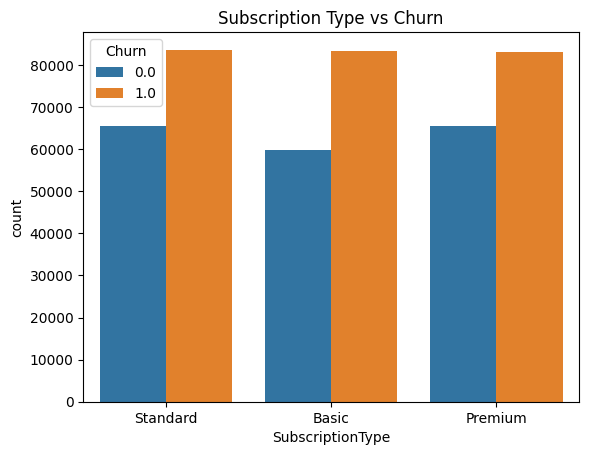

In [17]:
# visualize Subscription Type vs Churn
sns.countplot(data=df,x='SubscriptionType',hue='Churn')
plt.title('Subscription Type vs Churn')
plt.show()

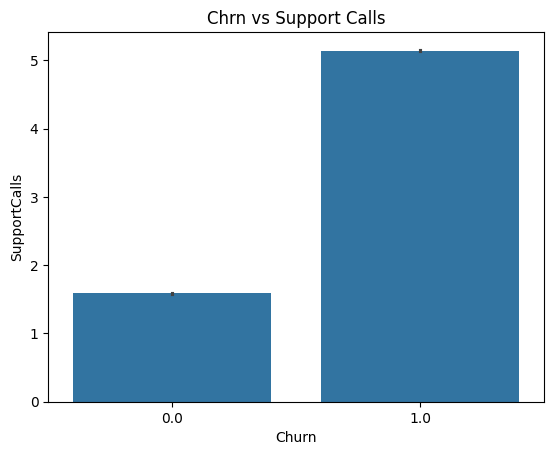

In [18]:
# visualize Churn vs Support Calls
sns.barplot(data=df,x='Churn',y='SupportCalls')
plt.title("Chrn vs Support Calls")
plt.show()

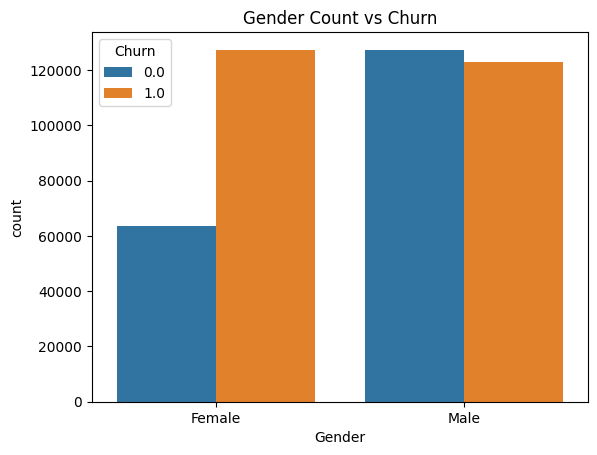

In [19]:
# visualize Gender vs Churn
sns.countplot(data=df,x='Gender',hue='Churn')
plt.title("Gender Count vs Churn")
plt.show()

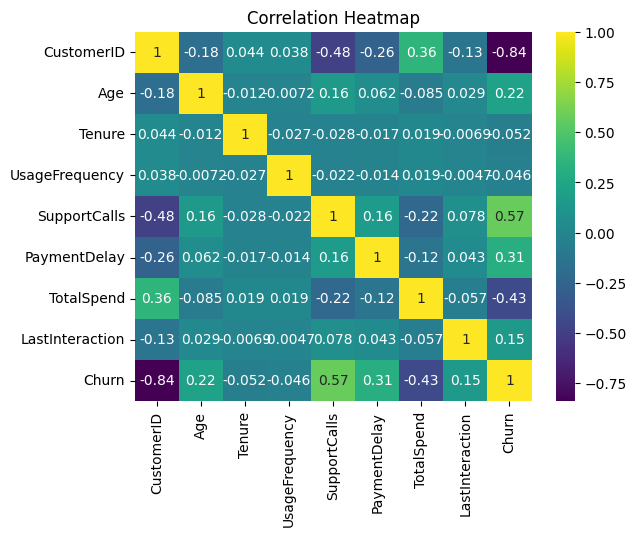

In [20]:
# correlation heatmap
sns.heatmap(df.corr(numeric_only=True),
annot=True,cmap="viridis")
plt.title('Correlation Heatmap')
plt.show()


## 📊 Key Insights found after EDA

Here’s what we've learned, put simply:

* **Problem Plan:** ⚠️ The **Basic plan** is losing the most customers. People on this plan are far less likely to stay with us (Churn = 0) compared to those on Standard or Premium plans.

* **Frustrated Customers:** 📞 The more a customer calls **support**, the more likely they are to leave. This strongly suggests they are unhappy with our service or running into too many problems.

* **Payment Issues:** 💳 Customers who **delay their payments** are also at a much higher risk of churning. This is a clear warning sign.

* **Gender Differences:** 🧑‍🤝‍🧑 **Male** customers seem to be happier with the service (or churn less) than **female** customers.

### Model Building and Evaluation

In [21]:
# feature-target split
X = df.drop('Churn',axis=1)
y = df['Churn']

In [22]:
# train-test split with stratification
# which Ensures the proportion of classes
# in the target variable is maintained
# in both training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.2,random_state = 42,stratify=y
)

In [23]:
# numerical and categorical columns
num_cols = ['CustomerID','Age','Tenure',
'UsageFrequency','SupportCalls','PaymentDelay',
'TotalSpend','LastInteraction'
]
cat_cols = ['Gender','SubscriptionType','ContractLength']

In [24]:
# defining column transformer
# to scale numerical features
# and one-hot encode categorical features
preprocessor = ColumnTransformer(
    [
        ('num',StandardScaler(),num_cols),
        ('cat',OneHotEncoder(),cat_cols)
    ]
)

In [25]:
# applying preprocessor fit_transform
# for training set and only transform for test set
# so that test data is not seen during training
X_train_norm = preprocessor.fit_transform(X_train)
X_test_norm = preprocessor.transform(X_test)

In [26]:
# checking shape of transformed training data
X_train_norm.shape

(352665, 16)

In [27]:
# checking shape of transformed test data
X_test_norm.shape

(88167, 16)

In [28]:
# defining function for modeling and
# metrics calculation
def modeling_metrics(X_train_norm,X_test_norm,y_train,y_test):
    predictions={}
    accuracy = {}
    precision = {}
    recall = {}
    f1 = {}
    roc_auc = {}
    models = {
        'LogisticRegression':LogisticRegression(class_weight='balanced'),
    'RandomForestClassifier':RandomForestClassifier(class_weight='balanced'),
    'GradientBoostingClassifier':GradientBoostingClassifier()
    }
    for name,model in models.items():
        model.fit(X_train_norm,y_train)
        y_pred = model.predict(X_test_norm)
        predictions[name] = y_pred
        accuracy[name] = accuracy_score(y_test,y_pred)
        precision[name] = precision_score(y_test,y_pred)
        recall[name] = recall_score(y_test,y_pred)
        f1[name] = f1_score(y_test,y_pred)
        roc_auc[name] = roc_auc_score(y_test,y_pred)
    metrics_df = pd.DataFrame({
        'Accuracy':accuracy,
        'Precision':precision,
        'Recall':recall,
        'F1-Score':f1,
        'ROC-AUC':roc_auc
    })
    return metrics_df,predictions,models

In [29]:
# getting modeling and metrics
# for different classifiers
# and models dictionary having trained models
metrics_df,predictions,models = modeling_metrics(
    X_train_norm,X_test_norm,y_train,y_test)

In [30]:
# predictions of all models
predictions

{'LogisticRegression': array([1., 0., 1., ..., 0., 0., 0.], shape=(88167,)),
 'RandomForestClassifier': array([1., 0., 1., ..., 0., 0., 0.], shape=(88167,)),
 'GradientBoostingClassifier': array([1., 0., 1., ..., 0., 0., 0.], shape=(88167,))}

In [31]:
# metrics dataframe of every model
metrics_df

,Accuracy,Precision,Recall,F1-Score,ROC-AUC
LogisticRegression,0.978802,0.986457,0.97602,0.981211,0.979233
RandomForestClassifier,0.999705,0.999540,0.99994,0.999740,0.999669
GradientBoostingClassifier,0.998628,0.998421,0.99916,0.998790,0.998545


In [32]:
# target variable distribution
y.value_counts(normalize=True)

Churn
1.0    0.567107
0.0    0.432893
Name: proportion, dtype: float64

In [33]:
# y_train distribution
y_train.value_counts(normalize=True)

Churn
1.0    0.567108
0.0    0.432892
Name: proportion, dtype: float64

In [34]:
# y_test distribution
y_test.value_counts(normalize=True)

Churn
1.0    0.567106
0.0    0.432894
Name: proportion, dtype: float64

In [35]:
# defining confusion matrices
# for each model
cmat_log_reg = confusion_matrix(y_true=y_test,y_pred=predictions['LogisticRegression'])
cmat_rand_for_clf= confusion_matrix(y_true=y_test,y_pred=predictions['RandomForestClassifier'])
cmat_grad_bst_clf = confusion_matrix(y_true=y_test,y_pred=predictions['GradientBoostingClassifier'])

In [36]:
# confusion matrix for logistic regression
cmat_log_reg

array([[37497,   670],
       [ 1199, 48801]])

In [37]:
# confusion matrix for gradient boosting classifier
cmat_grad_bst_clf

array([[38088,    79],
       [   42, 49958]])

In [38]:
# confusion matrix for random forest classifier
cmat_rand_for_clf

array([[38144,    23],
       [    3, 49997]])

In [39]:
# checking class distribution using Counter
print(Counter(y))

Counter({1.0: 249999, 0.0: 190833})


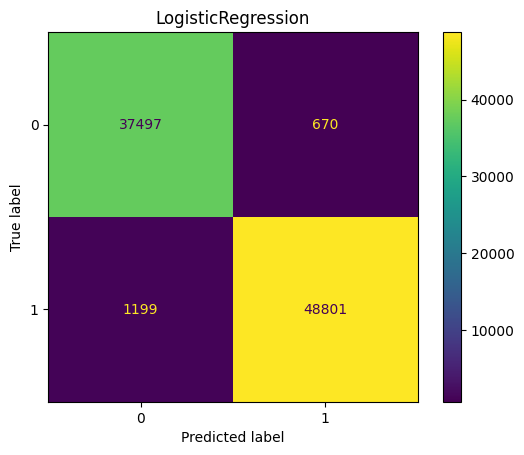

In [40]:
# displaying confusion matrix
# for logistic regression
ConfusionMatrixDisplay(
    confusion_matrix=cmat_log_reg
).plot()
plt.title("LogisticRegression")
plt.show()

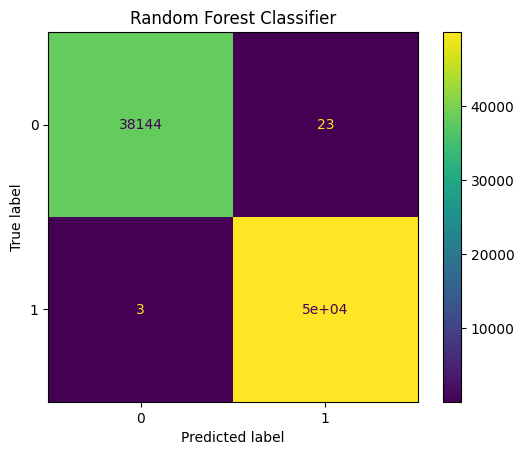

In [41]:
# displaying confusion matrix
# for random forest classifier
ConfusionMatrixDisplay(
    confusion_matrix=cmat_rand_for_clf
).plot()
plt.title("Random Forest Classifier")
plt.show()

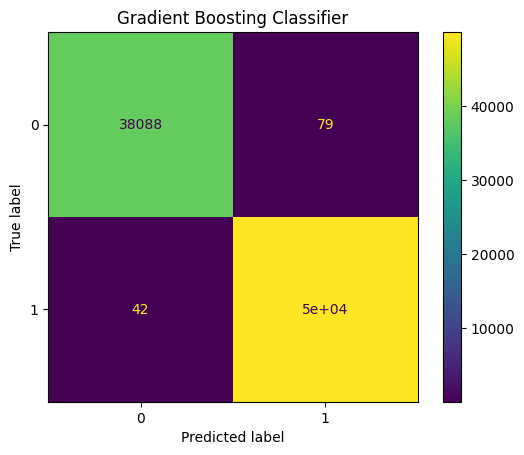

In [42]:
# displaying confusion matrix
# for gradient boosting classifier
ConfusionMatrixDisplay(
    confusion_matrix=cmat_grad_bst_clf
).plot()
plt.title("Gradient Boosting Classifier")
plt.show()

### Comparison of Performance Metrics of Different Classifiers

| Model                   | Accuracy | Precision | Recall  | F1-Score | Total Errors |
| ----------------------- | -------- | --------- | ------- | -------- | ------------ |
| **Logistic Regression** | 97.88%   | 98.60%    | 97.60%  | 98.10%   | ~1,869       |
| **Random Forest**       | 99.98%   | 99.96%    | 99.99% | 99.98%   | **19**       |
| **Gradient Boosting**   | 99.86%   | 99.84%    | 99.92%  | 99.88%   | **121**      |


### Checking for Imabalanced Data

In [43]:
# printing class distributions
# for target variable  original,
# train, and test sets
print(f"Y {y.value_counts(normalize=True)*100}")
print(f"y_train {y_train.value_counts(normalize=True)*100}")
print(f"y_test {y_test.value_counts(normalize=True)*100}")

Y Churn
1.0    56.71072
0.0    43.28928
Name: proportion, dtype: float64
y_train Churn
1.0    56.71076
0.0    43.28924
Name: proportion, dtype: float64
y_test Churn
1.0    56.710561
0.0    43.289439
Name: proportion, dtype: float64



---

### 🧩 Target Variable Distribution

The target variable **`Churn`** is **not imbalanced**. The class distribution is as follows:

**Overall (`Y Churn`)**

* 1.0 → 56.71%
* 0.0 → 43.29%

**Training Set (`y_train Churn`)**

* 1.0 → 56.71%
* 0.0 → 43.29%

**Test Set (`y_test Churn`)**

* 1.0 → 56.71%
* 0.0 → 43.29%

> ✅ Slightly imbalanced (56–43), but not enough to require resampling.

---




---

### 🧩 Handling Class Balance

As the dataset is only slightly imbalanced, there is **no need for resampling techniques** like SMOTE or class weighting in this case.

However, for experimental purposes, we will use the **`imbalanced-learn`** library to create a **50–50 balanced dataset** and observe how the model performance changes.

---

In [44]:
# applying SMOTE
# (Synthetic Minority Over-sampling Technique)
# to training data to handle class imbalance
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_norm, y_train)

In [45]:
# checking new class distribution
# after applying SMOTE
y_res.value_counts(normalize=True)*100

Churn
0.0    50.0
1.0    50.0
Name: proportion, dtype: float64

In [46]:
# getting modeling and metrics
# after applying SMOTE
metrics_df_after_sampling,predictions_after_sampling,models_after_sampling = modeling_metrics(
    X_res,X_test_norm,y_res,y_test
)

In [47]:
# evaluating metrics after sampling
metrics_df_after_sampling

,Accuracy,Precision,Recall,F1-Score,ROC-AUC
LogisticRegression,0.979062,0.986208,0.97674,0.981451,0.979422
RandomForestClassifier,0.999671,0.999600,0.99982,0.999710,0.999648
GradientBoostingClassifier,0.998491,0.998580,0.99876,0.998670,0.998450


### Models Performance Before and After Balancing the Dataset

| Model                   | Accuracy        | Precision       | Recall          | F1-Score        | ROC-AUC         |
| ----------------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| **Logistic Regression** | 97.88% → 97.91% | 98.65% → 98.62% | 97.60% → 97.67% | 98.12% → 98.15% | 97.92% → 97.94% |
| **Random Forest**       | 99.97% → 99.98% | 99.96% → 99.97% | 99.99% → 99.99% | 99.98% → 99.98% | 99.97% → 99.97% |
| **Gradient Boosting**   | 99.86% → 99.85% | 99.84% → 99.86% | 99.92% → 99.88% | 99.88% → 99.87% | 99.85% → 99.85% |



---

### Effect of Sampling on Model Performance

We can observe that **resampling the classes does not significantly affect our models’ performance**.

* Our target variable is already **relatively balanced** (56% vs 43%).
* Adjusting the class distribution to 50–50 using SMOTE **does not improve metrics noticeably**.
* This indicates that **class imbalance has minimal effect** on the model’s predictions on our dataset.

---

### Feature Importances and SHAP values

In [48]:
# getting feature names after preprocessing
num_features = preprocessor.named_transformers_['num'].get_feature_names_out()
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out()
all_features = list(num_features) + list(cat_features)

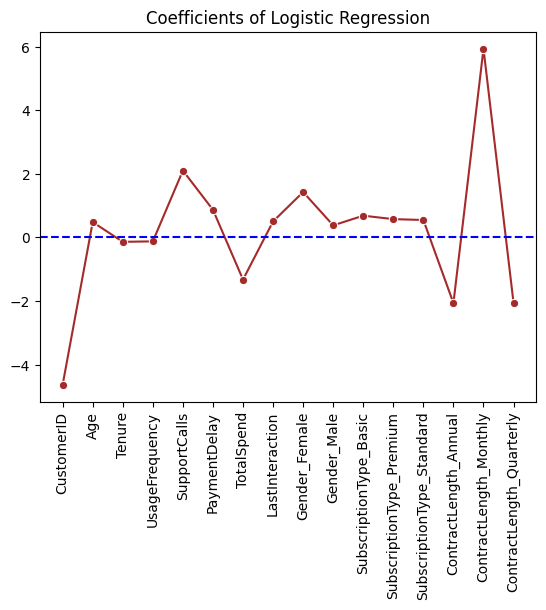

In [49]:
# visualizing feature importance
# for logistic regression
imp_log_reg = models['LogisticRegression'].coef_.flatten()
sns.lineplot(x=all_features,y=imp_log_reg,marker='o',
color='brown')
plt.axhline(0,linestyle='--',color='blue')
plt.xticks(rotation=90)
plt.title("Coefficients of Logistic Regression")
plt.show()

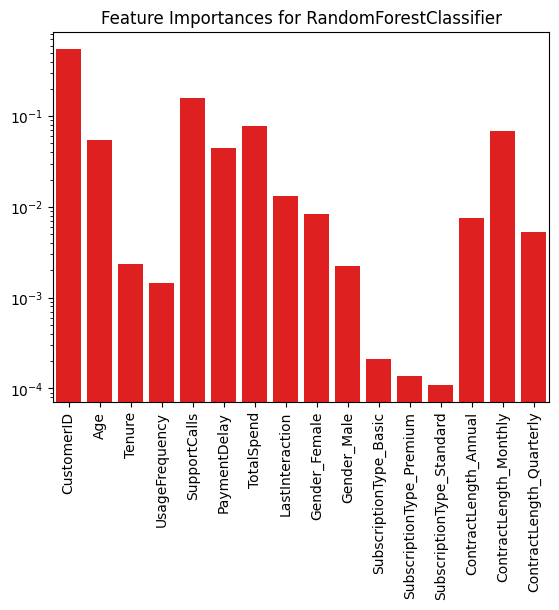

In [50]:
# visualizing feature importance
# for random forest classifier
imp_ran_for_clf = models['RandomForestClassifier'].feature_importances_
sns.barplot(x=all_features,y=imp_ran_for_clf,color='red')
plt.yscale('log')
plt.xticks(rotation=90)
plt.title("Feature Importances for RandomForestClassifier")
plt.show()

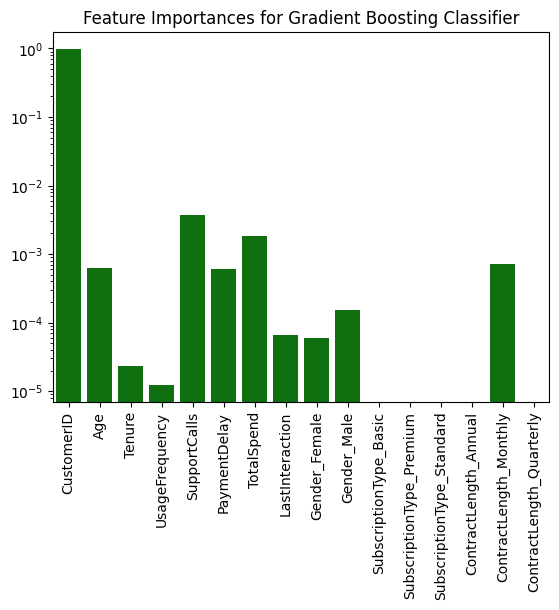

In [51]:
# visualizing feature importance
# for gradient boosting classifier
imp_grad_bst_clf = models['GradientBoostingClassifier'].feature_importances_
sns.barplot(x=all_features,y=imp_grad_bst_clf,color='green')
plt.yscale('log')
plt.xticks(rotation=90)
plt.title("Feature Importances for Gradient Boosting Classifier")
plt.show()

## Comparing Feature Importances of all Models

| Feature                  | Linear Regression (Weight) | Random Forest (Importance) | Gradient Boosting (Importance) |
|---------------------------|---------------------------|----------------------------|-------------------------------|
| Contract Length (Monthly) | 🔼 Highest (+)            | 🔹 Medium                  | 🔹 Medium                     |
| Support Calls             | 🔼 High (+)               | 🔼 High                    | 🔼 High                       |
| Gender (Female)           | 🔹 Medium (+)             | ⚪ Low                     | ⚪ Low                        |
| Customer ID               | 🔼 High (+)               | 🔼 High                    | 🔼 High                       |
| Total Spend               | 🔽 Negative (-)           | 🔼 High                    | 🔼 High                       |
| Payment Delay             | ⚪ Low                     | 🔹 Medium                  | 🔹 Medium                     |
| Usage Frequency           | ⚪ Low                     | ⚪ Low                      | 🔽 Very Low                   |
| Other Features            | ⚪ Low                     | ⚪ Low                      | ⚪ Low                        |

### Legend
- 🔼 : High positive impact on churn prediction  
- 🔽 : Negative impact (reduces churn)  
- 🔹 : Medium importance  
- ⚪ : Low or negligible importance  

### Observations
- **Logistic Regression:** `Contract Length (Monthly)`, `Support Calls`, `Gender (Female)`, and `Customer ID` positively influence churn; `Total Spend` has a negative effect.  
- **Random Forest:** `Customer ID`, `Support Calls`, `Total Spend` are the most important; `Contract Length` and `Payment Delay` are moderately important.  
- **Gradient Boosting:** Most important features are similar to Random Forest, but `Usage Frequency` is underestimated.  

**Conclusion:** Random Forest provides the most meaningful feature importance for predicting churn among the three models.


---

## Shap Value Analysis of all Models

Logistic Regression

d:\Data_Science\ds-ml-internship\.venv\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


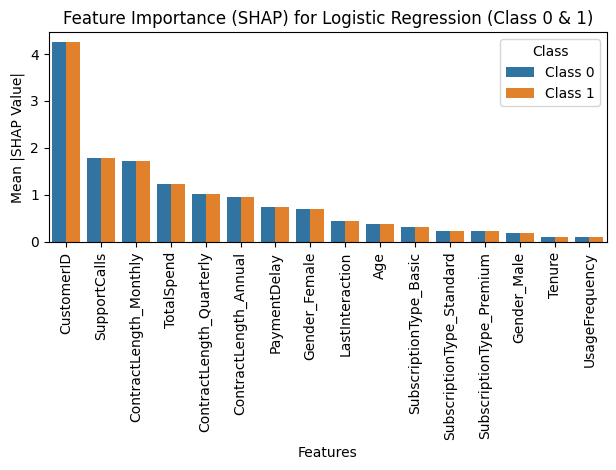

In [52]:
# visualizing SHAP values
# for Logistic Regression
# Sample 100 rows
X_sample = X_test_norm[np.random.choice(X_test_norm.shape[0], size=100, replace=False)]

# Create SHAP explainer for Logistic Regression
explainer = shap.LinearExplainer(
    models['LogisticRegression'], 
    X_train_norm, 
    feature_perturbation="interventional"   # <-- corrected
)

shap_values = explainer.shap_values(X_sample)

# For binary classification, shap_values is a 2D array (samples x features)
sv_class1 = shap_values
sv_class0 = -shap_values

# Compute mean absolute SHAP values per feature
mean_abs_shap_0 = np.abs(sv_class0).mean(axis=0)
mean_abs_shap_1 = np.abs(sv_class1).mean(axis=0)

# Create DataFrame for plotting
shap_df = pd.DataFrame({
    'Feature': all_features,
    'Class 0': mean_abs_shap_0,
    'Class 1': mean_abs_shap_1
})

# Convert to long format for Seaborn
shap_long = shap_df.melt(id_vars='Feature', var_name='Class', value_name='MeanAbsSHAP')

# Sort features by maximum importance across classes
feature_order = shap_df[['Class 0','Class 1']].max(axis=1).sort_values(ascending=False).index
features_sorted = shap_df.loc[feature_order, 'Feature']

# Plot grouped bar chart

sns.barplot(x='Feature', y='MeanAbsSHAP', hue='Class', data=shap_long, order=features_sorted)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Mean |SHAP Value|")
plt.title("Feature Importance (SHAP) for Logistic Regression (Class 0 & 1)")
plt.legend(title='Class')
plt.tight_layout()
plt.show()


Random Forest Classifier

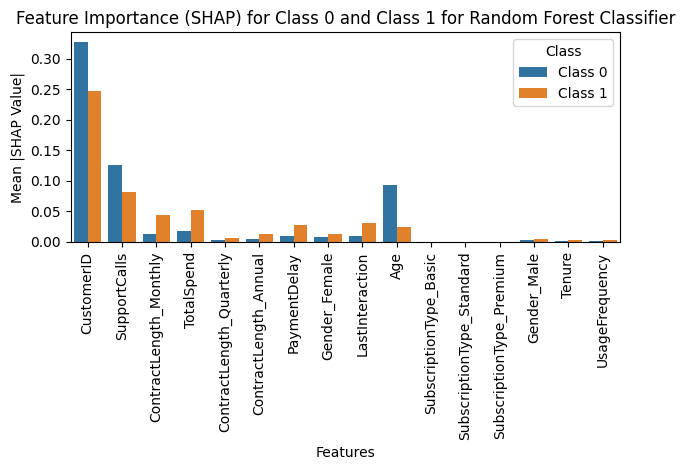

In [53]:
# visualizing SHAP values
# for Random Forest Classifier
# Sample 100 rows
X_sample = X_test_norm[np.random.choice(X_test_norm.shape[0], size=100, replace=False)]

# Create SHAP explainer
explainer = shap.TreeExplainer(models['RandomForestClassifier'])
shap_values = explainer.shap_values(X_sample)

# Get class 0 and class 1 SHAP values and transpose if needed
sv_class0 = shap_values[0]
sv_class1 = shap_values[1]

if sv_class0.shape[0] == X_sample.shape[1]:
    sv_class0 = sv_class0.T  # shape -> (n_samples, n_features)
if sv_class1.shape[0] == X_sample.shape[1]:
    sv_class1 = sv_class1.T  # shape -> (n_samples, n_features)

# Compute mean absolute SHAP values per feature
mean_abs_shap_0 = np.abs(sv_class0).mean(axis=0)
mean_abs_shap_1 = np.abs(sv_class1).mean(axis=0)

# Create a DataFrame for plotting
shap_df = pd.DataFrame({
    'Feature': all_features,
    'Class 0': mean_abs_shap_0,
    'Class 1': mean_abs_shap_1
})

# Convert to long format for Seaborn
shap_long = shap_df.melt(id_vars='Feature', var_name='Class', value_name='MeanAbsSHAP')

# Plot

sns.barplot(x='Feature', y='MeanAbsSHAP', hue='Class', data=shap_long, order=features_sorted)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Mean |SHAP Value|")
plt.title("Feature Importance (SHAP) for Class 0 and Class 1 for Random Forest Classifier")
plt.legend(title='Class')
plt.tight_layout()
plt.show()


Gradient Boosting Classifier

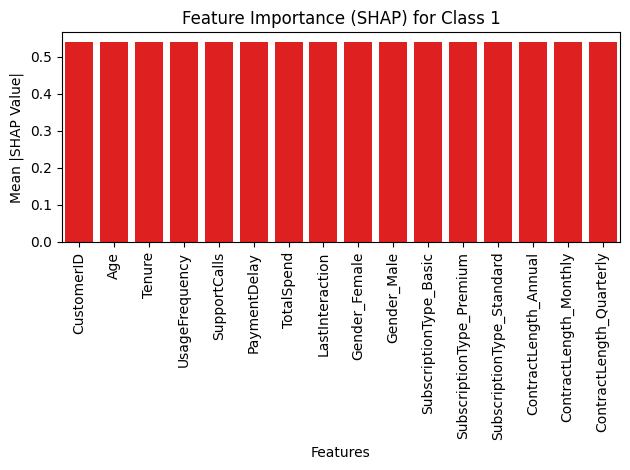

In [54]:
# visualizing SHAP values
# for Gradient Boosting Classifier
# Sample 100 rows
X_sample = X_test_norm[np.random.choice(X_test_norm.shape[0], size=100, replace=False)]

# Create SHAP explainer for GradientBoostingClassifier
explainer = shap.TreeExplainer(models['GradientBoostingClassifier'])
shap_values = explainer.shap_values(X_sample)

# Get class 1 SHAP values and transpose if needed
sv_class1 = shap_values[1]
if sv_class1.shape[0] == X_sample.shape[1]:
    sv_class1 = sv_class1.T  # shape -> (n_samples, n_features)

# Compute mean absolute SHAP values per feature
mean_abs_shap = np.abs(sv_class1).mean(axis=0)

# Create a DataFrame for plotting
shap_df = pd.DataFrame({
    'Feature': all_features,
    'MeanAbsSHAP': mean_abs_shap
})

# Sort features by importance (optional)
shap_df = shap_df.sort_values(by='MeanAbsSHAP', ascending=False)

# Plot using Seaborn
sns.barplot(x='Feature', y='MeanAbsSHAP', data=shap_df, color='red')
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Mean |SHAP Value|")
plt.title("Feature Importance (SHAP) for Class 1")
plt.tight_layout()
plt.show()


## Comparison of Shap Values of all Models

- **Logistic Regression:**  
  Key features include `Customer ID`, `Support Calls`, `Monthly Contract`, `Total Spend`, and `Quarterly Spend`.  
  Feature distributions are similar for both classes. 

- **Random Forest Classifier:**  
  Most impactful features are `Customer ID`, `Support Calls`, `Total Spend`, and `Monthly Contract`.  
  - **Class 0 (Non-Churn):** Higher values in `Age` and `Total Spend`.  
  - **Class 1 (Churn):** Higher values in `Customer ID` and `Support Calls`.  

- **Gradient Boosting Classifier:**  
  SHAP values are nearly uniform across features, providing limited insight.  

 

**Conclusion:** Random Forest offers the most meaningful insights into feature importance for predicting churn, while SHAP values and logistic regression weights provide less clear guidance.



---

## 🌟 Best Model

The **Random Forest Classifier 🌲** is the top performer for this classification task ✅.  

While all models handled the large dataset effectively 📊, **Random Forest** excels at capturing the complex relationships between features and the target variable 🔗.  

